## Importing all the dependencies

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from textblob import TextBlob
import matplotlib.pyplot as plt

## 1. Load Dataset from CSV File

In [ ]:

def load_dataset(file_path):
    """
    Loads a dataset from a specified CSV file.
    
    Args:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: A DataFrame containing the dataset.

    Raises:
        ValueError: If the required 'headline' column is missing.
    """
    df = pd.read_csv(file_path)
    if not {'headline'}.issubset(df.columns):
        raise ValueError("The dataset must contain a 'headline' column.")
    return df

## 2. Preprocess the Data

In [ ]:


def preprocess_data(df):
    """
    Preprocesses the text data by cleaning and standardizing it.

    Args:
        df (pd.DataFrame): Input dataset containing a 'headline' column.

    Returns:
        pd.DataFrame: Preprocessed dataset.
    """
    df = df.rename(columns={'headline': 'text'})  # Rename 'headline' column to 'text'.
    df['text'] = df['text'].str.lower()  # Convert text to lowercase.
    df = df.dropna(subset=['text'])  # Drop rows with missing text.
    df = df[df['text'].str.strip() != '']  # Drop rows with empty text.
    return df

## 3. Add Sentiment Scores and Classify

In [ ]:

def add_sentiment_classification(df):
    """
    Adds sentiment polarity scores and classifies text into sentiment categories.

    Args:
        df (pd.DataFrame): Input dataset with a 'text' column.

    Returns:
        pd.DataFrame: Dataset with added sentiment scores and classifications.
    """
    # Calculate polarity scores
    df['polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else np.nan)
    
    # Classify polarity into sentiment categories
    df['sentiment'] = pd.cut(
        df['polarity'], bins=[-1, -0.01, 0.01, 1], labels=['negative', 'neutral', 'positive']
    )

    # Drop rows with NaN sentiment values
    df = df.dropna(subset=['sentiment'])
    
    # Assign sentiment labels
    df['label'] = df['sentiment']
    return df


## 4. Extract Features Including Sentiment

In [ ]:

def extract_features_with_sentiment(df):
    """
    Extracts text features using TF-IDF vectorization and includes sentiment as additional features.

    Args:
        df (pd.DataFrame): Input dataset with 'text' and 'sentiment' columns.

    Returns:
        tuple: Feature matrix (X), fitted TF-IDF vectorizer, and sentiment column names.
    """
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df['text'])  # TF-IDF transformation.
    
    # One-hot encode sentiment categories
    sentiment_dummies = pd.get_dummies(df['sentiment'], drop_first=False)
    
    # Combine text features and sentiment features
    X_sentiment = np.hstack([X.toarray(), sentiment_dummies.values])
    return X_sentiment, vectorizer, sentiment_dummies.columns


## 5. Train and Evaluate the Decision Tree Model

In [ ]:

def train_and_evaluate(X, y, criterion="gini"):
    """
    Trains and evaluates a Decision Tree Classifier.

    Args:
        X (np.ndarray): Feature matrix.
        y (pd.Series): Target labels.
        criterion (str): Splitting criterion ('gini' or 'entropy').

    Returns:
        tuple: Trained classifier, training feature matrix, and training labels.
    """
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the decision tree classifier
    clf = DecisionTreeClassifier(
        criterion=criterion, max_depth=10, min_samples_split=10, random_state=42
    )
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model
    print(f"Criterion: {criterion}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

    return clf, X_train, y_train

## 6. Visualize the Decision Tree

In [ ]:

def visualize_tree(clf, feature_names, class_names):
    """
    Visualizes the trained Decision Tree Classifier.

    Args:
        clf (DecisionTreeClassifier): Trained classifier.
        feature_names (list): Names of the features used in training.
        class_names (list): Names of the target classes.
    """
    plt.figure(figsize=(15, 10))
    plot_tree(clf, feature_names=feature_names, class_names=class_names, filled=True, rounded=True)
    plt.show()

## Main Function

C:\Users\hp\AppData\Local\Temp\ipykernel_23188\3590070642.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['sentiment']


Criterion: gini
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

    negative       1.00      1.00      1.00        52
     neutral       1.00      1.00      1.00       389
    positive       1.00      1.00      1.00       159

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600


Confusion Matrix:
 [[ 52   0   0]
 [  0 389   0]
 [  0   0 159]]


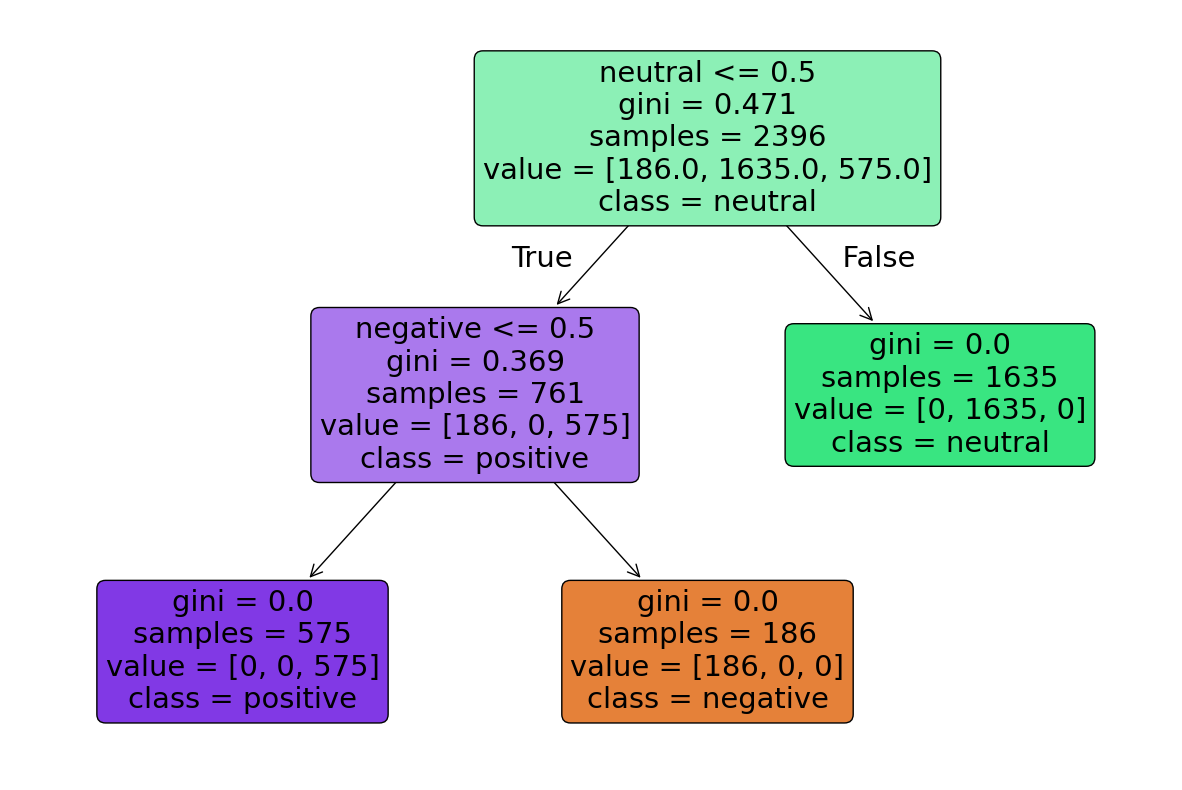

In [17]:

if __name__ == "__main__":
    # Path to the dataset
    file_path = "https://drive.google.com/uc?export=download&id=1vNkpqZHmQ0i1i1C9Zy0gQ8PqbUaZrqIR"


    # Load and preprocess data
    df = load_dataset(file_path)
    df = preprocess_data(df)

    # Add sentiment classification
    df = add_sentiment_classification(df)

    # Ensure no missing labels
    df = df.dropna(subset=['label'])

    # Extract features including sentiment
    X, vectorizer, sentiment_columns = extract_features_with_sentiment(df)

    # Train and evaluate the model using the Gini index
    clf, X_train, y_train = train_and_evaluate(X, df['label'], criterion="gini")

    # Visualize the decision tree
    class_names = sorted(df['label'].unique())
    feature_names = list(vectorizer.get_feature_names_out()) + list(sentiment_columns)
    visualize_tree(clf, feature_names, class_names)
